## Research agents

In [3]:
##
import os 
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")



llm = ChatGroq(model = "llama-3.2-1b-preview",
            groq_api_key = GROQ_API_KEY)

In [4]:
# Tavily tool initialization
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


In [7]:
#tool

# Python function to tool creation
@tool
def research(prompt):
    "Should do a web search for reserching about the given topic."
    response = tavily_tool.invoke(prompt)
    return response

tools = [research]

In [12]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

* Tools 

In [19]:

#tool 1: research
tavily_tool = TavilySearchResults(max_results=5)

#tool 2: NLP to ODATA
"""we can use Dynamic Prompt Generation for Natural Language to OData Query.
like this:
def natural_to_odata(entity, filters, select_fields=None, order_by=None, top=None):
    base_query = f"/{entity}?"
    
    # Add select fields
    if select_fields:
        base_query += f"$select={','.join(select_fields)}&"
    
    # Add filters
    if filters:
        filter_conditions = ' and '.join([f"{field} {condition}" for field, condition in filters.items()])
        base_query += f"$filter={filter_conditions}&"
    
    # Add ordering
    if order_by:
        base_query += f"$orderby={order_by}&"
    
    # Add top limit
    if top:
        base_query += f"$top={top}&"
    
    return base_query.rstrip('&')

# Example usage
entity = "Products"
filters = {"Category": "eq 'Electronics'", "Price": "gt 1000"}
select_fields = ["Name", "Price"]
order_by = "Price desc"
top = 5

odata_query = natural_to_odata(entity, filters, select_fields, order_by, top)
print(odata_query)

"""





'we can use Dynamic Prompt Generation for Natural Language to OData Query.\nlike this:\ndef natural_to_odata(entity, filters, select_fields=None, order_by=None, top=None):\n    base_query = f"/{entity}?"\n    \n    # Add select fields\n    if select_fields:\n        base_query += f"$select={\',\'.join(select_fields)}&"\n    \n    # Add filters\n    if filters:\n        filter_conditions = \' and \'.join([f"{field} {condition}" for field, condition in filters.items()])\n        base_query += f"$filter={filter_conditions}&"\n    \n    # Add ordering\n    if order_by:\n        base_query += f"$orderby={order_by}&"\n    \n    # Add top limit\n    if top:\n        base_query += f"$top={top}&"\n    \n    return base_query.rstrip(\'&\')\n\n# Example usage\nentity = "Products"\nfilters = {"Category": "eq \'Electronics\'", "Price": "gt 1000"}\nselect_fields = ["Name", "Price"]\norder_by = "Price desc"\ntop = 5\n\nodata_query = natural_to_odata(entity, filters, select_fields, order_by, top)\npri

In [13]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Defining State and Agent Node

In [15]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [16]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

### Tools and nodes

In [18]:
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should do research on the given topic and return a summary of that research",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [25]:
# text2Odata

text2Odata_agent = create_agent(
    llm,
    [python_repl],
    system_message = "Convert the given sentence into an OData query",
)

text2Odata_node = functools.partial(agent_node, agent = text2Odata_agent, name = "Text2OData")

In [22]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [23]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [27]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("text_2_Odata", text2Odata_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "text_2_Odata", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "text_2_Odata",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "text_2_Odata": "text_2_Odata",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

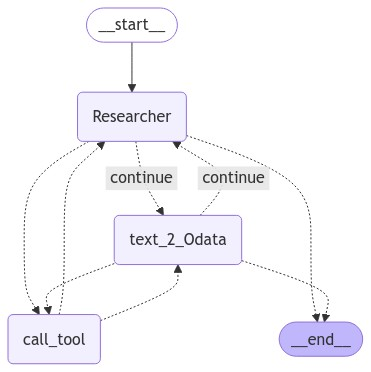

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:

events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content = "give me OData query for fateching top 4 salaries from employee table" 
            )
        ],
    },
    # Maximum number of steps to take in the graph
    #{"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='<function=tavily_search_results_json {"query":{"properties":{"query":"top 4 salaries","parameters":{"properties":{"table":"Employee"}},"optionalParameters":{"includingRelatedData":false,"select":"*"}},"type":"object"}}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 408, 'total_tokens': 456, 'completion_time': 0.014905254, 'prompt_time': 0.130206671, 'queue_time': -0.010676009, 'total_time': 0.145111925}, 'model_name': 'llama-3.2-1b-preview', 'system_fingerprint': 'fp_e9a4952513', 'finish_reason': 'stop', 'logprobs': None}, name='Researcher', id='run-0cb1c141-700d-44a7-8b2b-9aa19f72f28a-0', usage_metadata={'input_tokens': 408, 'output_tokens': 48, 'total_tokens': 456})], 'sender': 'Researcher'}}
----
{'text_2_Odata': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 454, 'total_tokens': 455, 'completion_

### hierarchical

In [38]:
from langgraph.graph import Graph
from langgraph.prebuilt import ToolExecutor
from langchain.tools import BaseTool
from langchain.agents import AgentExecutor, create_react_agent
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate


#from langchain_openai import ChatOpenAI
from typing import List, Dict

# Assume Trivial API is available
from langchain_community.tools.tavily_search import TavilySearchResults

# Define Trivial Tool
class TrivialResearchTool(BaseTool):
    name: str = "Trivial Research"
    description : str = "Useful for researching a given topic using Trivial API"

    def _run(self, query: str) -> str:
        trivial_api = TavilySearchResults(max_results=5)
        results = trivial_api.search(query)
        return "\n".join([f"- {result.title}: {result.summary}" for result in results[:5]])

    async def _arun(self, query: str) -> str:
        raise NotImplementedError("TrivialResearchTool does not support async")

# Define the agent
# Define the agent
def create_agent(llm):
    tools = [TrivialResearchTool()]
    prompt = PromptTemplate.from_template(
    """You are a research assistant. Use the following tool to gather information on the given topic:

    {tool_names}

    Use the above tools to answer the human's question. Your task is to provide a comprehensive summary of the findings.

    Human: {input}
    {agent_scratchpad}"""
)

    agent = create_react_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, verbose=True)

# Define the research function
def research(state):
    agent = state["agent"]
    question = state["question"]
    result = agent.invoke({"input": question})
    return {"result": result["output"]}

# Define the graph
def build_graph():
    graph = Graph()

    graph.add_node("research", research)

    graph.set_entry_point("research")
    graph.add_output("research")

    return graph

# Main function to run the agent
def main(question: str):
    llm = ChatGroq(model = "llama-3.2-1b-preview",
            groq_api_key = GROQ_API_KEY)
    agent = create_agent(llm)
    workflow = build_graph()
    app = workflow.compile()
    
    result = app.invoke({"agent": agent, "question": question})
    return result["result"]

# Example usage
if __name__ == "__main__":
    research_question = "What are the latest advancements in quantum computing?"
    result = main(research_question)
    print(result)

ValueError: Prompt missing required variables: {'tools'}